<a href="https://colab.research.google.com/github/Gru97/DeepLearningCourse/blob/main/session6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import kagglehub
import os

In [ ]:
model= models.vgg16(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_path="vgg16_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to vgg16_model.pth


In [ ]:
model= models.vgg16(pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<ipython-input-23-66f7f2cd7e15>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [ ]:
model.state_dict()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
path= kagglehub.dataset_download("tongpython/cat-and-dog")

In [ ]:
train_dataset_img = datasets.ImageFolder(root=os.path.join(path, 'training_set'))
test_dataset_img = datasets.ImageFolder(root=os.path.join(path, 'test_set'))

/root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/training_set/training_set/cats/cat.1.jpg


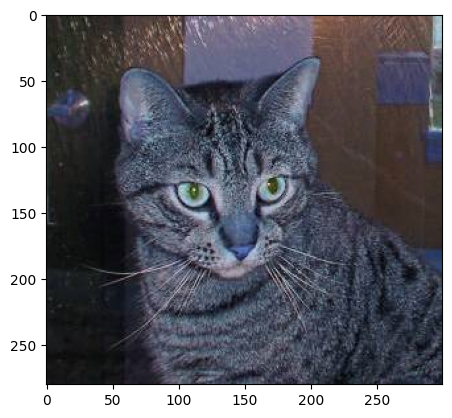

In [ ]:
f=train_dataset_img.samples[0][0]
print(f)
im = cv2.imread(f)
im.shape
plt.imshow(im)

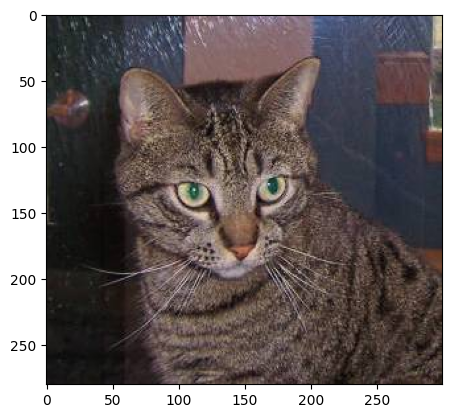

In [ ]:
plt.imshow(im[:,:,::-1])

In [ ]:
train_dataset_img.imgs[0][1]
#train_dataset.targets

0

In [ ]:
class CatsDogs(Dataset):
    def __init__(self, dataset):
      self.fpath=dataset.imgs
      self.normalize= transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
      self.targets= dataset.targets
    def __len__(self):
      return len(self.fpath)
    def __getitem__(self, ix):
      f= self.fpath[ix][0]
      target = self.targets[ix]
      im = cv2.imread(f)[:,:,::-1]
      im = cv2.resize(im, (224,224))
      im=torch.tensor(im/255)
      im = im.permute(2,0,1) #NCHW
      im=self.normalize(im)
      return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
data= CatsDogs(train_dataset_img)
data[20][0].shape


torch.Size([3, 224, 224])

In [ ]:
def get_model():
  model=models.vgg16(pretrained=False).to(device)
  model.load_state_dict(torch.load(model_path, map_location=device))
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool= nn.AdaptiveAvgPool2d(output_size = (1,1)) #1*1*512 # why didn't we go with inherent 7*7
  model.classifier= nn.Sequential(nn.Flatten(),
                                  nn.Linear(512,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(128,1),
                                  nn.Sigmoid())

  loss_fn= nn.BCELoss()
  optimizer= torch.optim.Adam(model.parameters(), lr = 1e-3)
  return model.to(device), loss_fn, optimizer

In [ ]:
train_dataset= CatsDogs(train_dataset_img)
test_dataset= CatsDogs(test_dataset_img)
train_dataloader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader= DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model, loss_fn, optimizer= get_model()
def accuracy(prediction, targets):
  is_correct = (prediction > 0.5) == targets
  return is_correct.cpu().numpy().sum()/targets.size(0)

def train(model, dataloader, optimize, criterion):
  model.train()
  train_loss=0
  train_acc=0
  for inputs, targets in dataloader:
    optimizer.zero_grad()
    outputs= model(inputs)
    loss= criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss+= loss.item()
    train_acc+= accuracy(outputs, targets)
  return train_loss/len(dataloader), train_acc/len(dataloader)

def validate(model, dataloader, criterion):
  model.eval()
  val_loss=0
  val_acc=0
  with torch.no_grad():
    for inputs, targets in dataloader:
      outputs= model(inputs)
      loss= criterion(outputs, targets)
      val_loss+= loss.item()
      val_acc+= accuracy(outputs, targets)
  return val_loss/ len(dataloader), val_acc / len(dataloader)

n_epochs= 10
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]
for epoch in range(n_epochs):
  train_loss, train_acc= train(model, train_dataloader, optimizer, loss_fn)
  val_loss, val_acc= validate(model, test_dataloader, loss_fn)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f"Epoch {epoch+1}/{n_epochs}")
  print(f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

<ipython-input-40-a1d278a381e5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
